# Assignment 1

## The Costs of Economic Nationalism

> Group members: Alexandros Gilch, Paul Grass, Julius Kappenberg, Tim Mensinger, Philipp Schirmer

This tasks aims to examine the _short-run_ effects of Brexit on GDP. To do so we employ the synthetic control method ([Abadie et al., 2010](https://economics.mit.edu/files/11859)). In particular we construct a _synthetic_ counterfactual of Britain which can then be used to compare Britain with and without Brexit. The synthetic Britain is constructed as a weighted average of OECD countries where the weights are set to minimize pre-treatment period moments. The rest of this notebook is structured as follows: In section 1 we implement the synthetic control method from scratch. This is done since available packages for R/Python did not seem trustworthy or simply poorly written. This part can be safely skipped by everyone not interested in the implementation. In section 2 we apply the method to our problem and consider robustness checks. Section 3 concludes.

> Remark. The tradeoff of using a fully reproducible&ast; notebook is that shown code can seem obstrusive. We choose this style nevertheless since we believe that the added value of results that are easy to reproduce plus the fact that the reader may directly check the code which produced a graph outweighs a less readable document. &ast;Reproducible given data and Python environment. At last we suggest reading this notebook online: [click here](https://tinyurl.com/assignment1-macro2-bonn).

## 1 Code

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sklearn_metrics

from functools import partial
from estimagic import minimize

sns.set_style("whitegrid")

### 1.1 Data Preparation

In [3]:
country_names = [
    "Australia",
    "Austria",
    "Belgium",
    "Canada",
    "Chile",
    "Czech Rep",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Ireland",
    "Israel",
    "Italy",
    "Japan",
    "Korea",
    "Luxembourg",
    "Mexico",
    "Netherlands",
    "New Zealand",
    "Norway",
    "Portugal",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    "US",
    "GB",
]

country_names_dict = {i + 1: name for i, name in enumerate(country_names)}

In [4]:
df = pd.read_excel("data/mydata.xlsx")  # change this path if necessary
df = df.assign(**{"name": df.country.replace(country_names_dict)})
df = df.set_index(["quarter", "name"]).sort_index()
df = df.drop("country", axis=1)

MAX_PERIODS = df.idxmax()[0][0]
BREXIT_PERIOD = 87

In [5]:
df.head()  # data structure

loggdp
quarter name               
1       Australia -0.016800
        Austria   -0.010487
        Belgium   -0.008201
        Canada    -0.001922
        Chile     -0.039199

### 1.2 Synthetic Control Method Functions

In [6]:
def prepare_data(data, treatment_period, treated_country):
    """Return dependent and independent data to be used in model.
    
    Args:
        data (pandas.DataFrame): The data frame with multiindex ["quarter", "name"]
            and one column containing values.
        treatment_period (int): The treatment period corresponding to a value in
            levelindex "quarter" of data.
        treated_country (str): The treated country unit corresponding to a value in
            levelindex "name" of data.
    
    Returns:
        y (pandas.Series): The dependent values with multiindex ["quarter", "name"].
        X (pandas.DataFrame): The independent feature matrix with index "quarter"
            and columns corresponding to "name".
    
    """
    y = df.loc[: treatment_period - 1, treated_country, :]
    y = y[y.columns[0]]
    X = df.loc[: treatment_period - 1, :, :].query("name != @treated_country")
    X = X.unstack().droplevel(0, axis=1)
    return y, X

In [7]:
def get_crit_func(y, X, weights, loss_type):
    """Get criterion function which will be optimized.
    
    This function takes in data in form of y, X returned by 
    :func:``prepare_data``as well as the loss function type and
    weights (weighting matrix V in model) and return the criterion
    function which depends only on the country weights. This
    function can then be passed to a standard optimizer to find
    optimal weights.
    
    Args:
        y (pandas.Series or numpy.ndarray[1d]): Dependent values.
        X (pandas.DataFrame or numpy.ndarray[2d]): Independent valeus.
        weights (numpy.ndarray[1d] or numpy.ndarray[2d]): Weighting array or
            weighting matrix. Has shape (len(y), len(y)).
        loss_type (str): Loss function type. Currently implemented are
            ["squared_error", "absolute_error"].
            
    Returns:
        crit_func (callable): The criterion function with single input.
    
    """
    def crit(params, y, X, loss_type):
        w = np.asarray(params["value"])
        loss = getattr(sklearn_metrics, loss_type)
        return loss(y, X @ w, sample_weight=weights)
    crit_func = partial(crit, y=y, X=X, loss_type=loss_type)
    return crit_func

In [8]:
def synthetic_control(
    data,
    treatment_period=None,
    treated_country="GB",
    loss_type="squared_error",
    weights=None,
    algorithm="scipy_lbfgsb",
):
    """Apply synthetic control method to our setting.
    
    Args:
        data (pandas.DataFrame): The data frame with multiindex ["quarter", "name"]
            and one column containing values.
        treatment_period (int): The treatment period corresponding to a value in
            levelindex "quarter" of data.
        treated_country (str): The treated country unit corresponding to a value in
            levelindex "name" of data.
        weights (numpy.ndarray[1d] or numpy.ndarray[2d]): Weighting array or
            weighting matrix. Has shape (len(y), len(y)).
        loss_type (str): Loss function type. Currently implemented are
            ["squared_error", "absolute_error"].
        algorithm (str): Which algorithm to choose for optimization. See implemented
            algorithms in estimagic.
        
    Returns:
        result_params (pandas.DataFrame): Result params data frame with index
            corresponding country names and value column corresponding to the
            country weights.
    
    """
    treatment_period = BREXIT_PERIOD if treatment_period is None else treatment_period
    
    # build crit func
    y, X = prepare_data(data, treatment_period, treated_country)
    crit_func = get_crit_func(y.values, X.values, weights, loss_type)
    
    # build params start vector for optimization
    x0 = np.ones((X.shape[1], 1))
    params = pd.DataFrame(x0, index=X.columns, columns=["value"]) / X.shape[1]
    params = params.assign(**{"type": "weight"})
    params = params.reset_index().set_index(["type", "name"])

    # optimize
    constraints = [{"loc": "weight", "type": "probability"}]
    result = minimize(crit_func, params, algorithm=algorithm, constraints=constraints)
    result_params = result["solution_params"][["value"]]
    return result_params

### 1.3 Plotting Functions

In [9]:
def plot_results(
    data, result, treatment_period=None, periods=None, ylim=None,
):
    """Plot results from synthetic control method.
    
    Plots true and synthetic country time series as well as all donors. Donors
    are given a transparency parameter corresponding to the weight to which
    they contribute to the synthetic country.
    
    Args:
        data (pandas.DataFrame): The data frame with multiindex ["quarter", "name"]
            and one column containing values.
        result (pandas.DataFrame): Results returned from :func:``synthetic_control``.
        treatment_period (int): The treatment period corresponding to a value in
            levelindex "quarter" of data.
        periods (list-like): Number of periods to plot.
        ylim (tuple[2d]): y-axis limits of plot.

    Returns:
        None
    
    """
    treatment_period = BREXIT_PERIOD if treatment_period is None else treatment_period
    # preparation
    if periods is not None:
        data = data.query("quarter in @periods")

    treated_country = (
        set(data.index.get_level_values("name"))
        - set(result.index.get_level_values("name"))
    ).pop()
    X = data.unstack().droplevel(0, axis=1)
    synthetic = X.drop(treated_country, axis=1).dot(result.droplevel(0))

    df = X.assign(**{"treated": X[treated_country], "synthetic": synthetic})
    df = df.reset_index().melt(id_vars="quarter", value_name="loggdp")

    alpha = result.droplevel(0)
    alpha.loc["treated", "value"] = 1
    alpha.loc["synthetic", "value"] = 1

    df = df.merge(alpha.reset_index().rename({"value": "alpha"}, axis=1))

    # plotting
    fig, ax = plt.subplots(1)
    fig.set_size_inches(14, 7)

    p = sns.lineplot(
        x="quarter",
        y="loggdp",
        data=df.query("name in ['treated', 'synthetic']"),
        hue="name",
        palette=["tab:blue", "tab:red"],
        ax=ax,
    )

    for country_name in df.name.unique():
        if country_name not in ["treated", "synthetic"]:
            _data = df.query("name == @country_name")
            sns.lineplot(
                x="quarter",
                y="loggdp",
                data=_data,
                alpha=_data["alpha"].unique()[0] * 1.5,
                ax=ax,
            )

    scaler = ylim[1] * 3 / 4 if ylim is not None else 1
    ax.text(BREXIT_PERIOD, 1.05 * scaler, "Brexit Vote", fontsize=14, ha="left")
    ax.axvline(BREXIT_PERIOD, color="black", linestyle="--", alpha=0.85)
    if treatment_period != BREXIT_PERIOD:
        ax.axvline(treatment_period, color="grey", linestyle="--")
        ax.text(
            treatment_period, 0.95 * scaler, "Placebo Period", fontsize=14, ha="left"
        )

    if ylim is not None:
        ax.set_ylim(ylim)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set(ylabel="Log-GDP", xlabel="Quarter")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)

    # write difference in plot
    tmp = df.query("name in ['synthetic', 'treated']").set_index(["quarter", "name"])[
        "loggdp"
    ]
    difference = tmp.loc[tmp.idxmax()[0], :].diff().dropna()[0]

    ax.legend(
        loc="upper left",
        bbox_to_anchor=(0.07, 0.75),
        frameon=False,
        labels=[
            f"Treated Country: {treated_country}",
            f"Synthetic. (Diff. to real on last period: {difference:.3f})",
        ],
        prop={"size": 14},
    )

    return None

In [10]:
def plot_placebo(
    data, placebo_periods, treated_country="GB", start_period=50,
):
    """Plot results from placebo tests for multiple placebo periods.
    
    Note that here we weight all periods the same to get comparable results across
    placebo periods.
    
    Args:
        data (pandas.DataFrame): The data frame with multiindex ["quarter", "name"]
            and one column containing values.
        placebo_periods (list-like): List of placebo periods.
        treated_country (str): The treated country unit corresponding to a value in
            levelindex "name" of data.
        start_period (int): Start plot from this period.

    Returns:
        None
    
    """
    data = data.query("quarter >= @start_period")
    X = data.unstack().droplevel(0, axis=1).drop(treated_country, axis=1)

    # placebos
    placebo_dfs = []
    for placebo_period in placebo_periods:
        result = synthetic_control(
            data, placebo_period, treated_country, loss_type="squared_error"
        )
        synthetic = X.dot(result.droplevel(0))
        placebo_dfs.append(synthetic.assign(**{"placebo_period": placebo_period}))

    placebo_df = pd.concat(placebo_dfs, axis=0).reset_index()

    # synthetic with all data
    result = synthetic_control(
        data, BREXIT_PERIOD, treated_country, loss_type="squared_error"
    )
    synthetic = X.dot(result.droplevel(0)).reset_index()

    # plotting
    fig, ax = plt.subplots(1)
    fig.set_size_inches(14, 7)

    true = sns.lineplot(
        x="quarter",
        y="loggdp",
        data=data.query("name == @treated_country").reset_index(),
        color="tab:blue",
        ax=ax,
        linewidth=2,
        label=treated_country,
        zorder=3,
    )

    synthetic = sns.lineplot(
        x="quarter",
        y="value",
        data=synthetic,
        color="tab:red",
        ax=ax,
        linewidth=2,
        label="Synthetic",
        zorder=2,
    )

    placebos = sns.lineplot(
        x="quarter",
        y="value",
        data=placebo_df,
        hue="placebo_period",
        ax=ax,
        palette=sns.dark_palette("gray", as_cmap=True),
        alpha=0.4,
        zorder=1,
    )

    h, l = ax.get_legend_handles_labels()
    labels = ["GB", "Synthetic", "Time placebos"]
    ax.legend(
        labels,
        loc="upper right",
        frameon=False,
        bbox_to_anchor=(0.25, 0.9),
        fontsize=14,
    )

    ax.text(BREXIT_PERIOD, 0.3, "Brexit Vote", fontsize=14, ha="left")
    ax.axvline(BREXIT_PERIOD, color="black", linestyle="--", alpha=0.85)

    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set(ylabel="Log-GDP", xlabel="Quarter")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)

    return None

## 2 Application

### 2.1 Results

We start by considering all data points from 1995 until the Brexit referendum. We weigh the 5 periods before the treatment period to achieve a closer fit between true Britain and synthetic Britain at the treatment period. Note that this is in line with the method which explicitly includes a weighting matrix. Note further that there is **no** weighting matrix which is uninformative in the Bayesian sense. Even a uniform weighting matrix makes an assumption about the structure of the problem. Hence our response to a question why we &mdash;arbitrarily one may argue&mdash; weigh the last 5 periods more is: Why not?

In [10]:
weights = np.ones(BREXIT_PERIOD - 1)
weights[-5 : BREXIT_PERIOD - 1] = 10

In [11]:
result = synthetic_control(df, loss_type="squared_error", weights=weights)

The two plots below compare Britain with its synthetic counterpart over the time-series. The second plot zooms in on the periods closer to the treatment period. The first plot shows that synthetic Britain follows the trajectory of true Britain very closely. However, after the treatment period the trajectories part ways with synthetic Britain continuing its trend while true Britain falls short. Under a multitude of assumptions one may argue that this is a causal effect. In the following subsection we provide robustness checks to strengthen the argument of a causal effect.

> Note that the transparent lines in the background of all subsequent figures represent the trajectories of the donor countries where the transparency weights are given by the synthetic control weights.

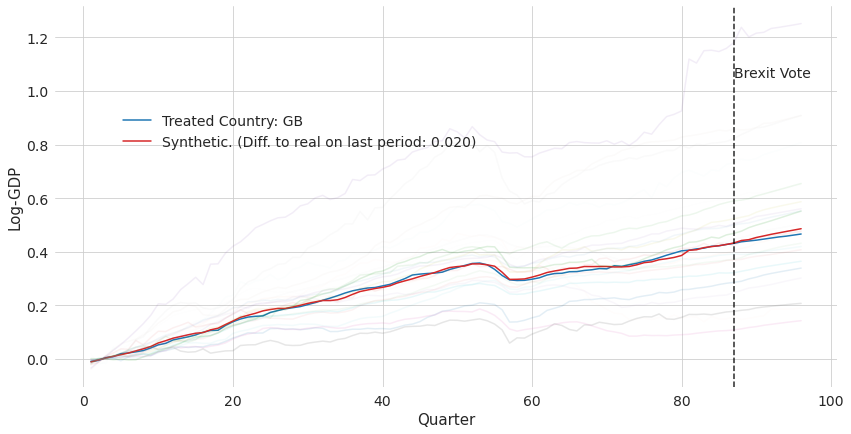

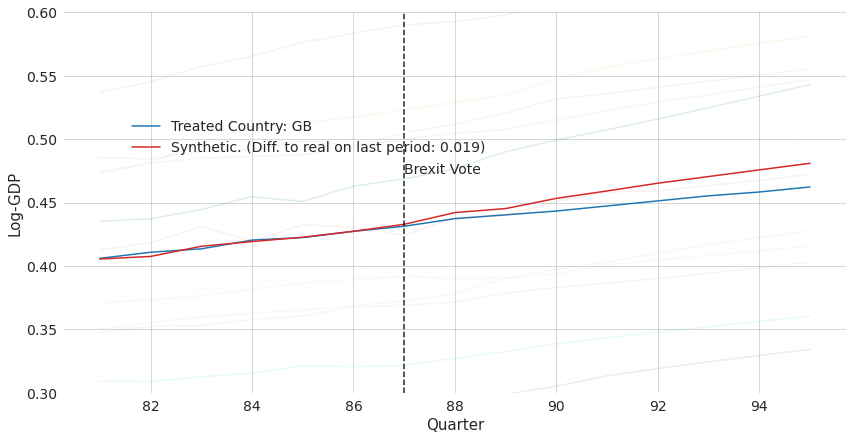

In [12]:
plot_results(df, result)
plot_results(df, result, periods=range(81, MAX_PERIODS), ylim=(0.3, 0.6))

### 2.2 Robustness Checks

#### 2.2.1 Placebo in-time tests

The following two figures present the results using a placebo period which is set to 73. We see that synthetic Britain fits the trajectory of true Britain very closely up to the placebo period. However, starting from the placebo period true Britain and its synthetic counterpart diverge. Providing even less evidence for our baseline claim, after the placebo period and until the last period true Britain has a higher growth than synthetic Britain. 

In [11]:
placebo_period = 73

placebo_weights = np.ones(placebo_period - 1)
placebo_weights[-5 : placebo_period - 1] = 10

In [12]:
result = synthetic_control(
    df, placebo_period, loss_type="squared_error", weights=placebo_weights
)

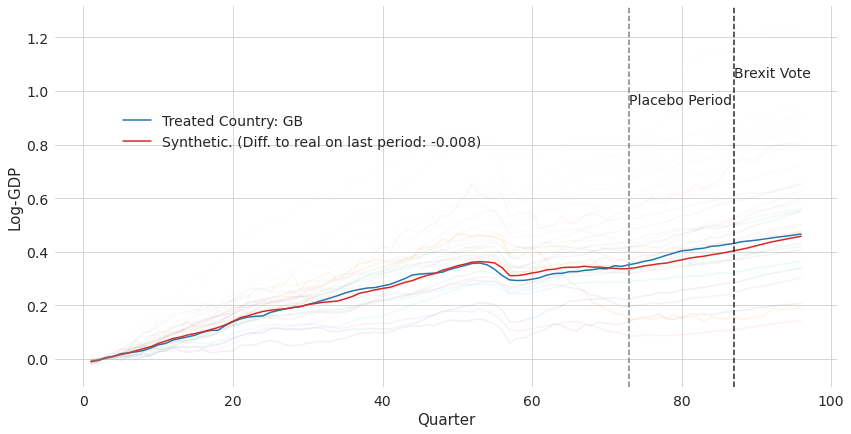

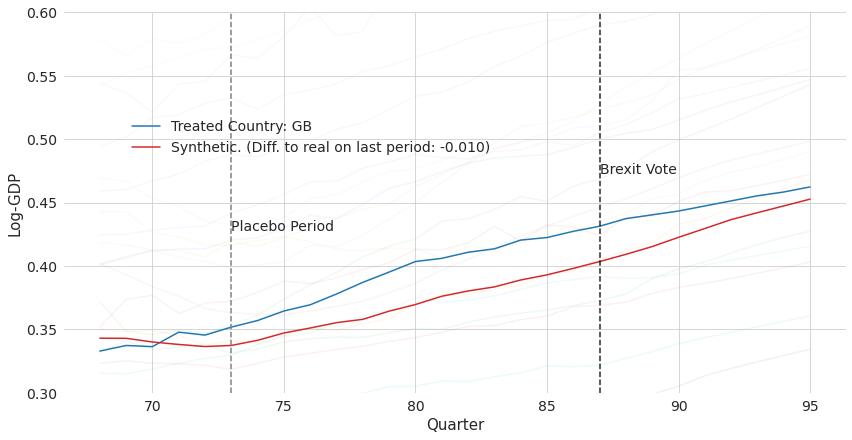

In [13]:
plot_results(df, result, placebo_period)
plot_results(
    df, result, placebo_period, periods=range(68, MAX_PERIODS), ylim=(0.3, 0.6)
)

**Multiple Tests**

Next we consider multiple placebo periods at once. This aims to replicate figure 3 from [Born et al. (2019)](https://academic.oup.com/ej/article/129/623/2722/5506774?guestAccessKey=4e92e28d-af1b-48d1-a373-cff0325d35d7). In comparison to Born et al. (2019) our multiple time placebos suggest that the results are not robust. For many time placebos log-GDP growths stays below true Britain. Nevertheless, we observe that the slopes of all placebos are higher than the slope of true Britain, which suggests that they would outperform true Britain after a longer time period. However, the departure of true Britain from this higher growth happens well before the Brexit vote. The figure suggests period 80 as the start for this departure.   

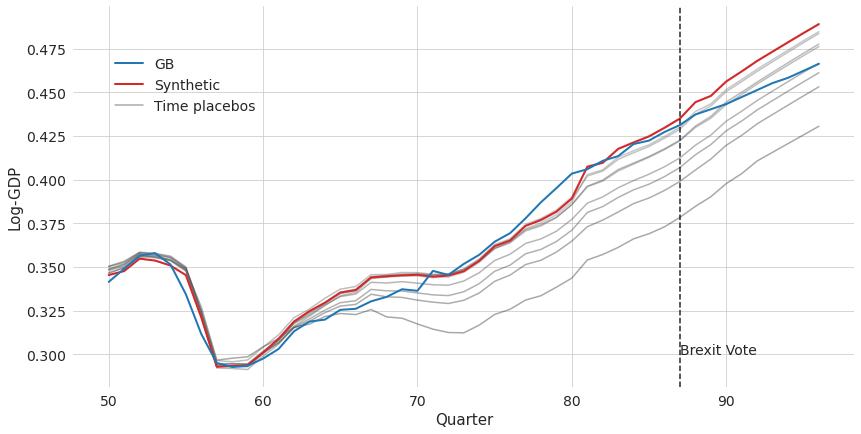

In [16]:
plot_placebo(df, placebo_periods=range(70, BREXIT_PERIOD, 2))

#### 2.2.2 Placebo in-unit tests

Next we consider what happens when we change the treated unit to be one of Germany, Canada, Switzerland or Israel. We see that a naive execution of the method suggests a positive effect for Germany, a neutral effect for Canada and a negative effect for Switzerland. Moreover we see that Israel's pre-treatment moments cannot be well approximated by the synthetic version. The latter observation showing that for the synthetic control method to work properly the donor pool has to include similar countries. An even more extreme example is Ireland which has a log-GDP growth that is nearly uniformly above all other countries. With weights constrained to be probabilities there cannot exist a synthetic version which matches the moments accurately.

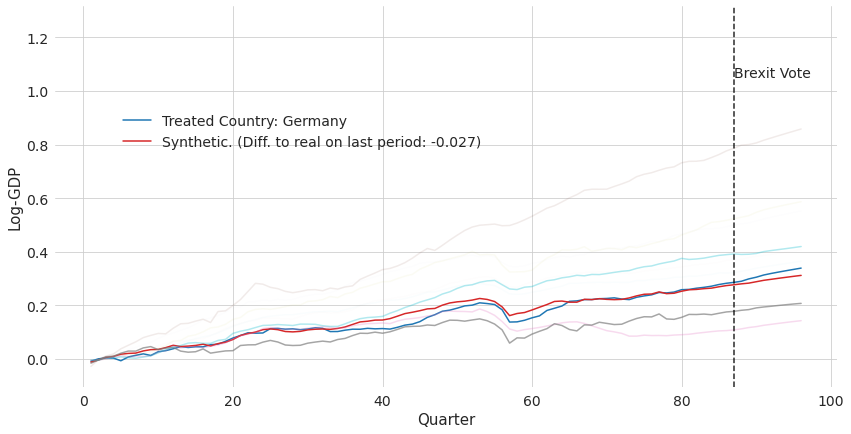

In [17]:
result = synthetic_control(
    df, treated_country="Germany", loss_type="squared_error", weights=weights
)
plot_results(df, result)

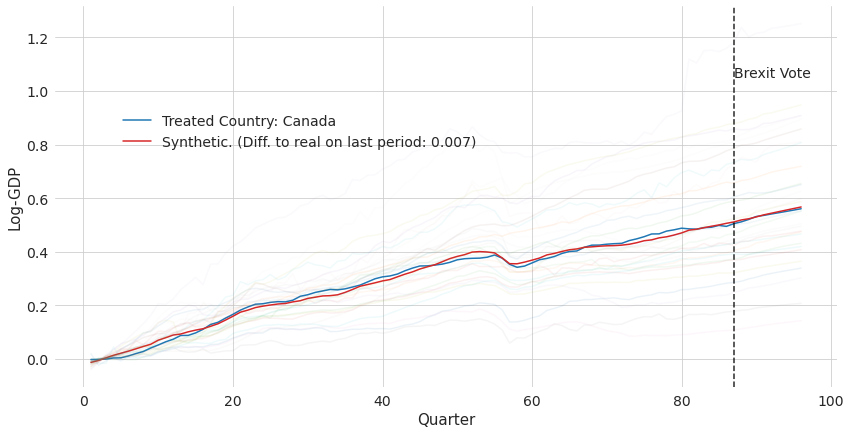

In [18]:
result = synthetic_control(
    df, treated_country="Canada", loss_type="squared_error", weights=weights
)
plot_results(df, result)

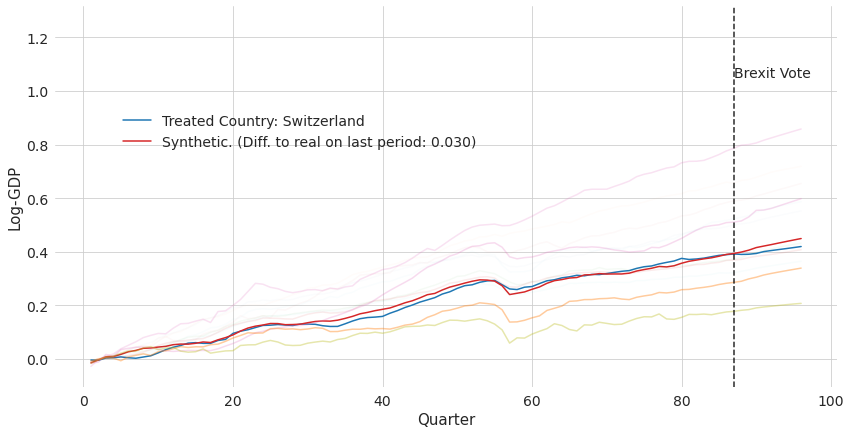

In [19]:
result = synthetic_control(
    df, treated_country="Switzerland", loss_type="squared_error", weights=weights
)
plot_results(df, result)

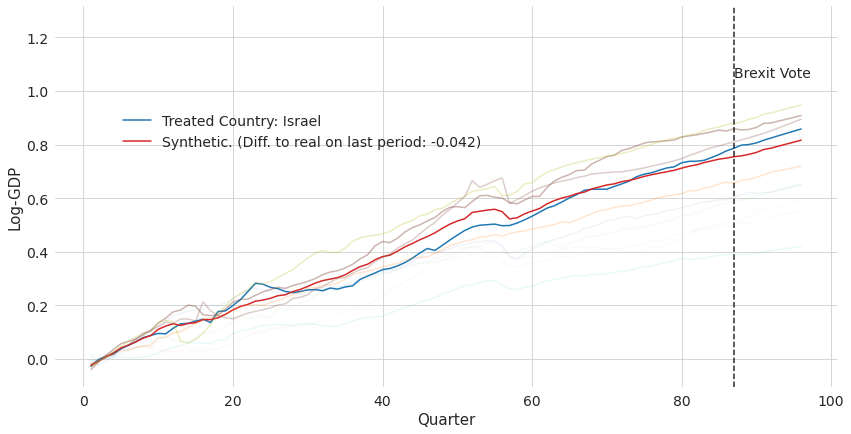

In [20]:
result = synthetic_control(
    df, treated_country="Israel", loss_type="squared_error", weights=weights
)
plot_results(df, result)

## 3 Conclusion

In our reproducing effort we cannot find the same evidence as in Born et al. (2019). Even though that our baseline effects are similar to the ones reported in Born et al. (2019) our robustness checks tell a different story. Moreover, our additional placebo in-unit tests suggest that the effect sizes of our baseline result could also develop for untreated units.

In general to gain a better understanding of the medium and long-term effects the study would have to be repeated once more post-treatment periods have materialized. Furthermore, this can also help in the study of short-run effects as it could aid in differentiating stochastic effects from structural effects. However, a major problem will be that Britains behavior during the Corona crisis departed significantly from the behavior of most european states. It may be impossible to untangle the effects from Brexit and Corona.

As a final remark, by implementing the method we realized that results may be sensitive to a multitude of factors. For example, if the donor pool is large enough and some countries have similar trajectories in the pre-treatment periods, many local optima may exist. But in such a case, a reasonable synthetic counterpart could be build with possibly very different sets of weights, even though post-treatment trajectories may differ substantially for the synthetic versions build from these sets of weights. A fully robust analysis would need to account not only for placebo tests but also e.g. for uncertainty and variability induced by using different optimizers that solve the constrained least-squares problem.